# Task 1: Retrieving and Preparing the Data

In [1]:
import datetime as dt

# Importing packages - Pandas, Numpy, Seaborn, Scipy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sys
import matplotlib.style as style; style.use('fivethirtyeight')
from scipy.stats import zscore, norm

np.random.seed(0)

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Oversampling
# from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [2]:
# Reading the data as dataframe
file_path = "./online_retail_II.xlsx"
df = pd.read_excel(file_path)

## Attribute Information

* **`Invoice`**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* **`StockCode`**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* **`Description`** : Product (item) name. Nominal.
* **`Quantity`**: The quantities of each product (item) per transaction. Numeric.
* **`InvoiceDate`**: Invice date and time. Numeric. The day and time when a transaction was generated.
* **`Price`**: Unit price. Numeric. Product price per unit in sterling (£).
* **`Customer ID`**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* **`Country`**: Country name. Nominal. The name of the country where a customer resides.

## Data Shape

In [3]:
# Print info of the dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
# Print out dataset's shape and the total number of missing values
print("Dataset has" , df.shape[0], "rows  and" , df.shape[1], "columns. There are ", df.isna().any().sum(), "columns with missing values")

Dataset has 525461 rows  and 8 columns. There are  2 columns with missing values


## Data Cleaning
### Dropping duplicated values

In [5]:
# Count total number of duplicated rows
df.duplicated().sum()

6865

In [6]:
# Drop all duplicated rows
df.drop_duplicates(inplace=True)
# Count total number of duplicated rows
df.duplicated().sum()

0

### Dealing with Missing values

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107833
Country             0
dtype: int64

In specific, the **Description** column has 2928 missing values while **CustomerID** column has 107927 null values.

#### Exploratory Data Analysis
**Invoice:**
Three types of invoices:
- Start with Number
- Start with Letter A
- Start with Letter C

In [8]:
# Invoice records beginning with 'A'
df[df['Invoice'].str.contains('A', na = False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [9]:
# Invoice records beginning with 'C'
df[df["Invoice"].str.contains("C", na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


**StockCode & Description**
- StockCode contains 5-7 character strings mostly numbers
- Some unique StockCodes are M, B, TEST001, D

Each product's item distinguished by **StockCode** has a product description. However, with the same StockCode, the description is sometimes left blank due to error data entry. 

In [10]:
# Check null values in Description column
df[df["Description"].isnull() == True].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom


In [11]:
# Example of same stockcode but blank description
df[df['StockCode']==20683]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.00,NaN,United Kingdom
24774,491435,20683,RAIN GIRL CHILDS UMBRELLA,1,2009-12-11 10:10:00,3.25,14606.0,United Kingdom
43854,493252,20683,NaN,1,2009-12-22 13:51:00,0.00,NaN,United Kingdom


In [12]:
# Check unique description values
df['Description'].unique()

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., '*Boombox Ipod Classic', 'faulty',
       'Dotcom sales'], dtype=object)

**Quantity:**

The quantity column not only displays the quantity of items purchased, but it also displays the amount of cancelled/returned items by encoding the cancelled transactions as negative. Each of these cancelled transactions is associated with the Invoice Number. However, there is only 1 instance whose invoice starts with C but the Quantity is positive (1).

In [13]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [14]:
print('The number of entries with negative quantity', df[(df['Quantity'] < 0)].shape[0])

The number of entries with negative quantity 12302


In [15]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [16]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [17]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] >= 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom


**InvoiceDate**

In [18]:
max_invoice_date = df['InvoiceDate'].max()
min_invoice_date = df['InvoiceDate'].min()
date_fmt = '%Y-%m-%d'
print('The data ranges from {} to {}'.format(min_invoice_date.strftime(date_fmt), 
                                             max_invoice_date.strftime(date_fmt) ))

The data ranges from 2009-12-01 to 2010-12-09


**Price**

In [19]:
df['Price'].describe()

count    518596.000000
mean          4.716176
std         147.090460
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: Price, dtype: float64

- The maximum and minimum values could be considered to be outliers since the mean value is only **4.742955**.<br>
- The column also contains negative values.


In [20]:
# Check for rows with negative values
negative_prices = df[df['Price'] < 0]
negative_prices

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


- The **Description** column of the above rows suggests that these rows might not contain the data of real transactions. These could be made-up data which were produced to serve the purpose of dealing the bad debts.
- Based on the above hypothesis, dropping these rows could be reasonable.

In [21]:
# Dropping by using indexes
df.drop([179403, 276274, 403472], inplace=True)

In [22]:
# Check if the rows have been dropped
negative_prices = df[df['Price'] < 0]
negative_prices

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


**Customer ID**

In [23]:
df['Customer ID'].describe()

count    410763.000000
mean      15353.621857
std        1681.657665
min       12346.000000
25%       13979.000000
50%       15311.000000
75%       16797.000000
max       18287.000000
Name: Customer ID, dtype: float64

**Country**

In [24]:
df['Country'].describe()

count             518593
unique                40
top       United Kingdom
freq              479044
Name: Country, dtype: object

In [25]:
df['Country'].value_counts()

United Kingdom          479044
EIRE                      9660
Germany                   8120
France                    5754
Netherlands               2768
Spain                     1271
Switzerland               1187
Portugal                  1098
Belgium                   1053
Channel Islands            906
Sweden                     901
Italy                      729
Australia                  654
Cyprus                     546
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [26]:
# Check for space characters
df['Country'].str.isspace().sum()

0

- **Country** column contains names of 40 different countries without typos or duplicates or containing any space.
- **United Kingdom** appears to be the most frequent value to show up.

#### Detecting Outliers

<AxesSubplot: >

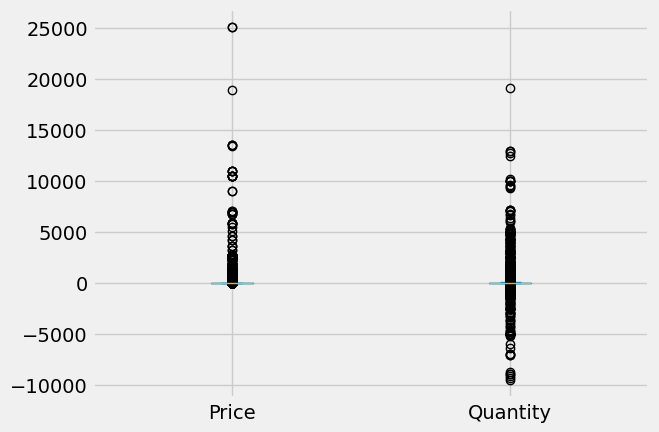

In [27]:
# Boxplot graph for Price and Quantity column
df[["Price","Quantity"]].plot(kind="box")

#### Sanity Check

Those columns having null values in **Description, Customer ID** and **Price** equals 0 are dropped because they are considered failed transactions.

In [28]:
# Drop failed transactions
idx = df[(df['Description'].isnull()) & (df['Customer ID'].isnull()) & (df['Price']==0)].index.values
df.drop(idx, inplace=True)

In [29]:
# Check the missing values
# Feature Engineering
print(df.isnull().any().sum()," are dropped")

1  are dropped


## Add new columns

In [30]:
# Add new column: OrderCancelled
def map_order_cancelled(row):
    return 1 if "C" not in str(row).upper() else 0
    
df["OrderCancelled"] = df["Invoice"].map(map_order_cancelled)

In [31]:
def map_international_shipping(row):
    return 1 if row == "United Kingdom" else 0
df['International Shipping']= df['Country'].map(map_international_shipping)
df['International Shipping'].value_counts()

1    476116
0     39549
Name: International Shipping, dtype: int64

In [32]:
# Add new column: TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [33]:
# Add date related columns
df['Week']=df['InvoiceDate'].dt.week
df["Week Day"] = df["InvoiceDate"].dt.weekday
df['Day']=df['InvoiceDate'].dt.day
df['Month']=df['InvoiceDate'].dt.month
df["Quarter"] = df["InvoiceDate"].dt.quarter
df["Year"] = df["InvoiceDate"].dt.year

def map_is_weekend(row):
    return 1 if row == 5 or row == 6 else 0
df['isWeekend']= df['Week Day'].map(map_is_weekend)

# Task 2: Feature Engineering

Text(0.5, 1.0, 'Correlation Matrix of Data')

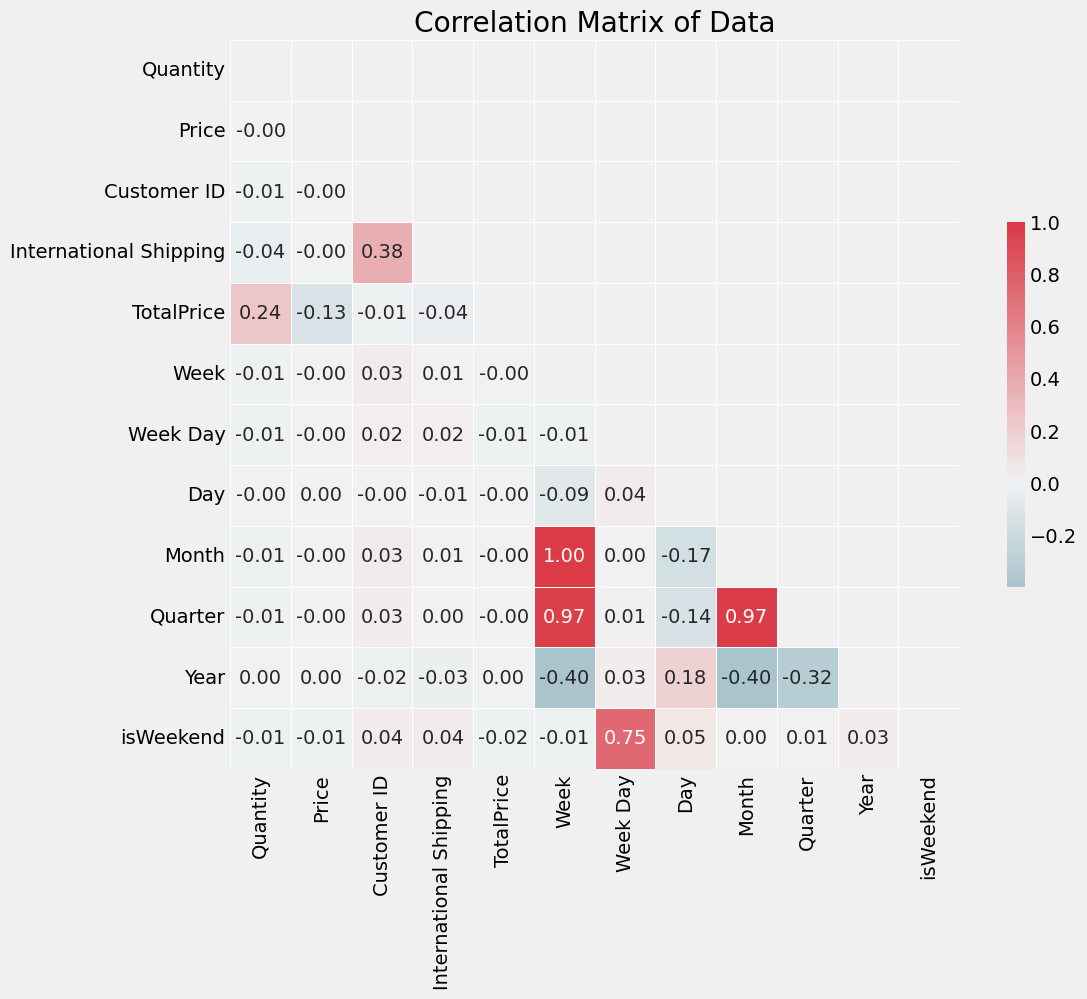

In [34]:
corr = df.drop('OrderCancelled', axis = 1).corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt="0.2f")
ax.set_title('Correlation Matrix of Data')